We need to import libraries

In [13]:
import nltk
from nltk.corpus import stopwords
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import re
import string
from wordcloud import WordCloud, STOPWORDS 
import spacy
from tqdm import tqdm
import os
import random
import warnings
from spacy.util import compounding
from spacy.util import minibatch
warnings.filterwarnings("ignore")

In [69]:
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
from transformers import *
import tokenizers

In [36]:
train_data =pd.read_csv('../kaggle/tweet-sentiment-extraction/train.csv')
test_data =pd.read_csv('../kaggle/tweet-sentiment-extraction/test.csv')


In [11]:
lets see the size of our data


In [37]:
print(train_data.shape)
print(test_data.shape)

(27481, 4)
(3534, 3)


In [38]:
print(train_data[train_data['text'].isnull()])
print(train_data[train_data['selected_text'].isnull()])

         textID text selected_text sentiment
314  fdb77c3752  NaN           NaN   neutral
         textID text selected_text sentiment
314  fdb77c3752  NaN           NaN   neutral


In [39]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


Drop the missing values


In [40]:
# drop the row with missing data
train_data.dropna(inplace = True)
# reset index and drop the index column made by reset_index()
train_data = train_data.reset_index(drop = True)

In [41]:
train_data.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,169c3017b0,what have you been up to ?,good,neutral
freq,1,1,199,11117


In [45]:
# Calculating no of words in each tweet in 'text' column
train_data['N_text_words'] = train_data['text'].apply(lambda tweet : len(tweet.split()))

# Calculating no of words in each tweet in 'selected_text' column
train_data['N_selected_text_words'] = train_data['selected_text'].apply(lambda tweet : len(tweet.split()))

# Calculating difference in no. of words in text and selected_text
train_data['N_words_difference'] = train_data['N_text_words'] - train_data['N_selected_text_words']


In [46]:
print("There are {0} unique sentiments having values {1}".format(train_data['sentiment'].nunique(), train_data['sentiment'].unique()))

There are 3 unique sentiments having values ['neutral' 'negative' 'positive']


In [47]:
# Counting number of neutral sentiments 
n_neutral = train_data['sentiment'].loc[train_data['sentiment'] == 'neutral'].count()
# Counting number of positive sentiments 
n_positive = train_data['sentiment'].loc[train_data['sentiment'] == 'positive'].count()
# Counting number of negative sentiments 
n_negative = train_data['sentiment'].loc[train_data['sentiment'] == 'negative'].count()

In [48]:
print(f"Neutral tweets : {n_neutral}")
print(f"Positive tweets : {n_positive}")
print(f"Negative tweets : {n_negative}")

Neutral tweets : 11117
Positive tweets : 8582
Negative tweets : 7781


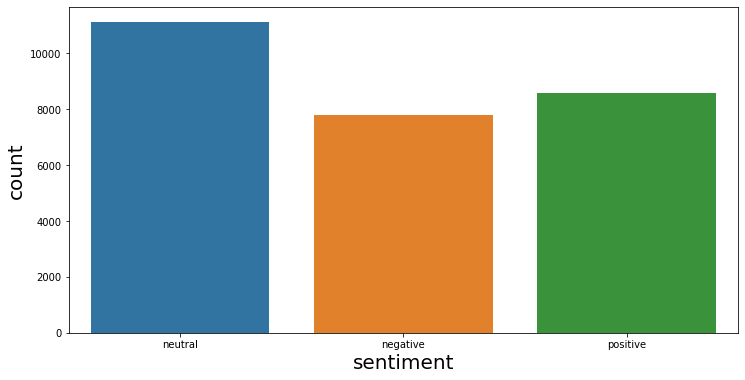

In [50]:
plt.figure(figsize=(12,6))
plt.xlabel('Sentiments',fontsize = 20)
plt.ylabel('Count',fontsize = 20)
sns.countplot(x='sentiment',data=train_data)

In [51]:
sentiments = ['Neutral', 'Positive', 'Negative']
fig = go.Figure(data = [go.Pie(labels = sentiments, values=[n_neutral, n_positive, n_negative])])
fig.show()

In [52]:
# breaking the dataframe sentimentwise

# dataframe with all neutral sentiments
df_neutral = train_data.loc[train_data['sentiment'] == 'neutral']
# dataframe with all positive sentiments
df_positive = train_data.loc[train_data['sentiment'] == 'positive']
# dataframe with all negative sentiments
df_negative = train_data.loc[train_data['sentiment'] == 'negative']

### Preprocessing


#### Remove Punctuations


In [53]:
def clean_text(text):
    
    text = str(text).lower() #lowercase
    text = re.sub('\[.*?\]', '', text)#reomve text in square brackets
    text = re.sub('https?://\S+|www\.\S+', '', text)# remove links
    text = re.sub('<.*?>+', '', text)#remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [55]:
train_data['text_cleaned'] = train_data['text'].apply(lambda x:clean_text(x))
train_data['selected_text_cleaned'] = train_data['selected_text'].apply(lambda x:clean_text(x))

#### Remove StopWords


In [57]:
STOPWORDS = stopwords.words('english')
def remove_stopwords(text):
    return [word for word in text.split() if word not in STOPWORDS]
train_data['text_cleaned'] = train_data['text_cleaned'].apply(lambda x : remove_stopwords(x))
train_data['selected_text_cleaned'] = train_data['selected_text_cleaned'].apply(lambda x : remove_stopwords(x))

Lets see how the mostcommon words  after removing stopwords

In [60]:
def get_all_words(df_col):
    all_words_text = []
    for row in df_col:
        for word in row:
            all_words_text.append(word)
    return all_words_text

all_words_text = get_all_words(train_data['text_cleaned'])
all_words_selected_text = get_all_words(train_data['selected_text_cleaned'])

In [61]:
def most_common_words(all_words):
    return nltk.FreqDist(all_words)

In [62]:
# for 'text' column
words = []
frequency = []
freqDist = most_common_words(all_words_text)
for word, freq in freqDist.most_common(20):
        words.append(word)
        frequency.append(freq)

for i in range(20):
    print(f'{words[i]} : {frequency[i]}')

fig = px.bar(x=frequency, y=words, title='Top 20 Most Commmon Words in Text', orientation='h', 
             width=700, height=700,color=words)
fig.show()

im : 3020
day : 2044
good : 1549
get : 1426
like : 1346
go : 1267
dont : 1200
love : 1122
work : 1112
going : 1096
today : 1096
got : 1072
cant : 1020
happy : 976
one : 971
lol : 948
time : 942
know : 930
u : 923
really : 908


In [ ]:
all_words_neutral = get_all_words(train_data[train_data['sentiment'] == 'neutral']['text_cleaned'])
all_words_positive = get_all_words(train_data[train_data['sentiment'] == 'positive']['text_cleaned'])
all_words_negative = get_all_words(train_data[train_data['sentiment'] == 'negative']['text_cleaned'])

####  Most common words - sentimentwise

In [63]:
all_words_neutral = get_all_words(train_data[train_data['sentiment'] == 'neutral']['text_cleaned'])
all_words_positive = get_all_words(train_data[train_data['sentiment'] == 'positive']['text_cleaned'])
all_words_negative = get_all_words(train_data[train_data['sentiment'] == 'negative']['text_cleaned'])

In [64]:
# for 'neutral' sentiment
words = []
frequency = []
freqDist = most_common_words(all_words_neutral)
for word, freq in freqDist.most_common(20):
        words.append(word)
        frequency.append(freq)

for i in range(20):
    print(f'{words[i]} : {frequency[i]}')

fig = px.bar(x=frequency, y=words, title='Top 20 Most Commmon Words with Neutral Sentiment', orientation='h', 
             width=700, height=700,color=words)
fig.show()

im : 1054
get : 623
go : 576
day : 503
dont : 491
going : 479
work : 477
like : 457
lol : 454
got : 453
today : 435
time : 425
know : 415
back : 410
one : 402
u : 383
see : 353
cant : 344
home : 336
want : 325


In [65]:
# for 'positive' sentiment
words = []
frequency = []
freqDist = most_common_words(all_words_positive)
for word, freq in freqDist.most_common(20):
        words.append(word)
        frequency.append(freq)

for i in range(20):
    print(f'{words[i]} : {frequency[i]}')

fig = px.bar(x=frequency, y=words, title='Top 20 Most Commmon Words with positive Sentiment', orientation='h', 
             width=700, height=700,color=words)
fig.show()

day : 1223
good : 1046
love : 875
happy : 840
im : 740
mothers : 627
thanks : 553
great : 478
like : 413
hope : 396
get : 367
fun : 344
today : 342
lol : 338
nice : 334
u : 326
night : 319
really : 307
got : 302
one : 292


In [66]:
# for 'negative' sentiment
words = []
frequency = []
freqDist = most_common_words(all_words_negative)
for word, freq in freqDist.most_common(20):
        words.append(word)
        frequency.append(freq)

for i in range(20):
    print(f'{words[i]} : {frequency[i]}')

fig = px.bar(x=frequency, y=words, title='Top 20 Most Commmon Words with Negative Sentiment', orientation='h', 
             width=700, height=700,color=words)
fig.show()

im : 1226
like : 476
dont : 469
cant : 463
get : 436
miss : 422
go : 401
sad : 389
work : 386
sorry : 340
really : 339
going : 334
today : 319
day : 318
got : 317
bad : 300
feel : 285
one : 277
hate : 262
know : 262


#### Word Clouds

In [67]:
def plot_wordcloud(all_words):
    stopwords = set(STOPWORDS)
    more_stopwords = {'u', "im"}
    stopwords = stopwords.union(more_stopwords)
    all_words = " ".join(all_words)
    wordcloud = WordCloud(width = 400, height = 200, 
                background_color ='white',
                max_words = 200,
                stopwords = stopwords,
                min_font_size = 10)
    wordcloud = wordcloud.generate(all_words)
    
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show() 

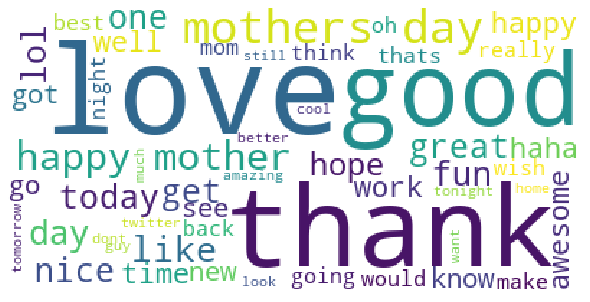

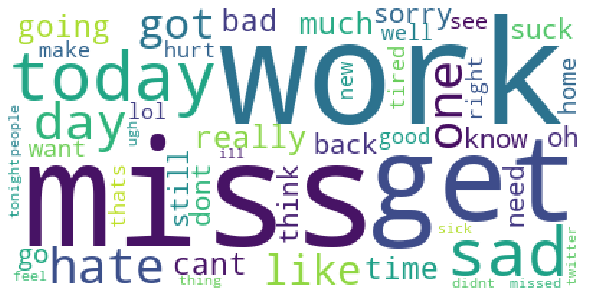

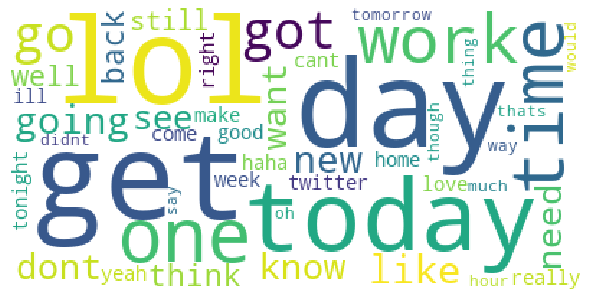

In [68]:
plot_wordcloud(all_words_positive)
plot_wordcloud(all_words_negative)
plot_wordcloud(all_words_neutral)

In [78]:
MAX_LEN = 96
from tokenizers import ByteLevelBPETokenizer
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file='vocab-roberta-base.json', 
    merges_file='merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)


In [ ]:
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}
train = pd.read_csv('../input/tweet-sentiment-extraction/train.csv').fillna('')
train.head()

In [81]:
MAX_LEN = 96
PATH=('../kaggle/tweet-sentiment-extraction')
tokenizer = tokenizers.ByteLevelBPETokenizer('merges-roberta-base.txt',lowercase=True)
    

In [84]:
MAX_LEN = 96
tokenizer = tokenizers.ByteLevelBPETokenizer('vocab-roberta-base.json') 
